# Actor Critic Algorithm

In [31]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from gym import spaces
import matplotlib.pyplot as plt

In [32]:
class ContinuousInventoryEnv(gym.Env):
    def __init__(self, min_inv=-10, max_inv=10, max_order=10, horizon=100):
        super().__init__()
        self.min_inv, self.max_inv = min_inv, max_inv
        self.max_order = max_order
        self.horizon = horizon
        self.p, self.a_cost, self.b_cost = 1.0, 1.0, 2.0
        self.sp = 0.0  # salvage price per unit actually served

        self.observation_space = spaces.Box(
            low=np.array([min_inv, 0], dtype=np.float32),
            high=np.array([max_inv, horizon], dtype=np.float32),
            dtype=np.float32
        )
        self.action_space = spaces.Box(
            low=np.array([0.], dtype=np.float32),
            high=np.array([max_order], dtype=np.float32),
            dtype=np.float32
        )
        # print(self.action_space)

    def reset(self):
        self.s = np.random.uniform(self.min_inv, self.max_inv + 1)
        self.t = 0
        return np.array([self.s, self.t], dtype=np.float32)

    def step(self, action):
        # ensure we get a numeric array, then a scalar
        arr = np.array(action, dtype=np.float32)
        a = float(min(self.max_order, max(0, arr.flatten()[0])))

        # sample demand
        w = np.random.uniform(0, 10)

        # compute how much demand is actually served:
        available = self.s + a
        served = float(max(0.0, min(available, w)))

        # next inventory BEFORE clamp
        s_next = available - w
        # clamp to physical bounds
        self.s = float(min(self.max_inv, max(self.min_inv, s_next)))
        self.t += 1

        # ordering cost + holding/backlog cost
        order_cost = self.p * a
        if self.s >= 0:
            inv_cost = self.a_cost * self.s
        else:
            inv_cost = self.b_cost * (-self.s)
        cost = order_cost + inv_cost

        # reward = revenue from served units - total cost
        reward = self.sp * served - cost

        done = (self.t >= self.horizon)
        obs = np.array([self.s, self.t], dtype=np.float32)
        return obs, reward, done, {}


In [33]:
class Actor(nn.Module):
    def __init__(self, obs_dim, hidden_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
        )
        self.mean_head = nn.Linear(hidden_dim, action_dim)
        self.log_std = nn.Parameter(torch.zeros(action_dim))

    def forward(self, x):
        features = self.net(x)
        mean = self.mean_head(features)
        std = torch.exp(self.log_std)
        return mean, std

class Critic(nn.Module):
    def __init__(self, obs_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(-1)

In [34]:
def train(env, actor, critic, num_episodes=1000, gamma=0.99, lr=3e-4):
    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic_opt = optim.Adam(critic.parameters(), lr=lr)

    episode_rewards = []
    avg_rewards = []
    last_inventory_history = None

    for ep in range(1, num_episodes + 1):
        state = env.reset()
        state = torch.tensor(state, dtype=torch.float32)
        done = False
        ep_reward = 0.0
        inventory_hist = []

        while not done:
            inventory_hist.append(env.s)
            mean, std = actor(state)
            dist = torch.distributions.Normal(mean, std) # maybe change the distribution from which the action is chosen
            action = dist.sample()
            action_clamped = torch.clamp(action, 0, env.max_order)

            next_state, reward, done, _ = env.step([action_clamped.item()])
            next_state = torch.tensor(next_state, dtype=torch.float32)
            reward_t = torch.tensor(reward, dtype=torch.float32)

            value = critic(state)
            next_value = critic(next_state)
            td_target = reward_t + (1 - int(done)) * gamma * next_value
            advantage = td_target - value

            # update actor
            log_prob = dist.log_prob(action).sum()
            actor_loss = -log_prob * advantage.detach()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # update critic
            critic_loss = advantage.pow(2)
            critic_opt.zero_grad(); critic_loss.backward(); critic_opt.step()

            state = next_state
            ep_reward += reward

        episode_rewards.append(ep_reward)
        avg_rewards.append(np.mean(episode_rewards[-50:]) if len(episode_rewards) >= 50 else np.mean(episode_rewards))
        last_inventory_history = inventory_hist

        if ep % 50 == 0:
            print(f"Episode {ep}: Total Reward = {ep_reward:.2f}")

    # Plot rewards
    plt.figure()
    plt.plot(episode_rewards, label='Episode Reward')
    plt.plot(avg_rewards, label='50-Episode Moving Avg')
    plt.xlabel('Episode'); plt.ylabel('Reward'); plt.legend(); plt.title('Learning Curve'); plt.grid(True)
    plt.show()

    # Plot value function vs inventory at time t=0
    s_vals = np.arange(env.min_inv, env.max_inv + 1)
    states = torch.tensor(np.stack([s_vals, np.zeros_like(s_vals)], axis=1), dtype=torch.float32)
    with torch.no_grad():
        v_vals = critic(states).numpy()
    plt.figure()
    plt.plot(s_vals, v_vals)
    plt.xlabel('Inventory Level (s)'); plt.ylabel('Value V(s, t=0)'); plt.title('Value Function at t=0'); plt.grid(True)
    plt.show()

    # Plot inventory trajectory of last episode
    plt.figure()
    plt.plot(last_inventory_history)
    plt.xlabel('Time Step'); plt.ylabel('Inventory Level'); plt.title('Inventory Trajectory (Last Episode)'); plt.grid(True)
    plt.show()


Episode 50: Total Reward = -1984.46
Episode 100: Total Reward = -2049.61
Episode 150: Total Reward = -2079.73
Episode 200: Total Reward = -1986.34
Episode 250: Total Reward = -1961.61
Episode 300: Total Reward = -2000.00
Episode 350: Total Reward = -1989.73
Episode 400: Total Reward = -2000.00
Episode 450: Total Reward = -1984.73
Episode 500: Total Reward = -1985.48
Episode 550: Total Reward = -1956.53
Episode 600: Total Reward = -1961.71
Episode 650: Total Reward = -2000.00
Episode 700: Total Reward = -1999.56
Episode 750: Total Reward = -1992.17
Episode 800: Total Reward = -1981.20
Episode 850: Total Reward = -1975.12
Episode 900: Total Reward = -1955.05
Episode 950: Total Reward = -1964.57
Episode 1000: Total Reward = -1964.17


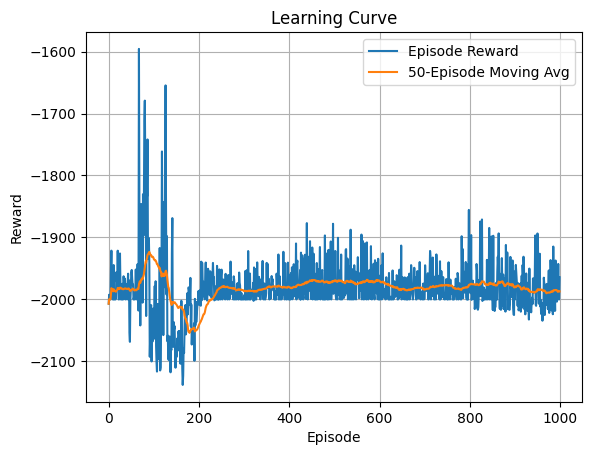

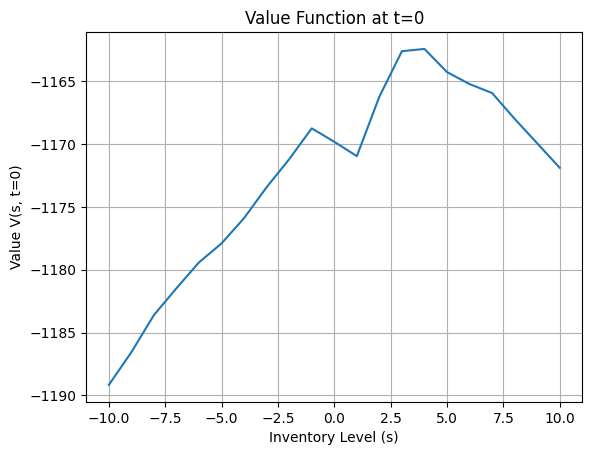

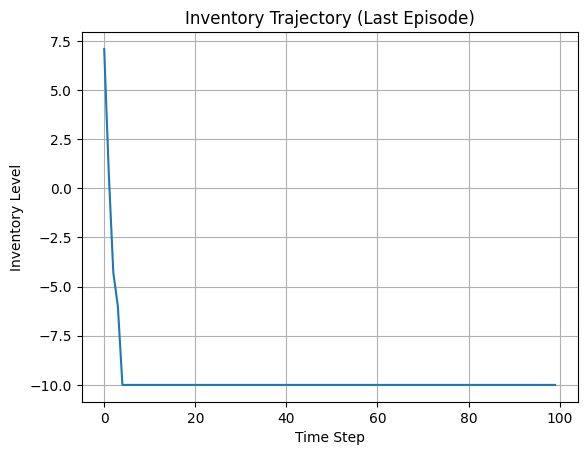

In [35]:
if __name__ == "__main__":
    env = ContinuousInventoryEnv()
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 128

    actor = Actor(obs_dim, hidden_dim, action_dim)
    critic = Critic(obs_dim, hidden_dim)

    train(env, actor, critic)

# Uniform distribution

In [ ]:
from torch.distributions import Normal, TransformedDistribution, TanhTransform, AffineTransform


def train(env, actor, critic, num_episodes=1000, gamma=0.99, lr=3e-4):
    actor_opt = optim.Adam(actor.parameters(), lr=lr)
    critic_opt = optim.Adam(critic.parameters(), lr=lr)

    episode_rewards, avg_rewards, last_inv = [], [], None

    for ep in range(1, num_episodes + 1):
        state = torch.tensor(env.reset(), dtype=torch.float32)
        done, ep_reward, inv_hist = False, 0.0, []

        while not done:
            inv_hist.append(env.s)
            # Use Uniform policy instead of Normal
            mean, std = actor(state)
            base = Normal(mean, std)
            # 1) Tanh to get into (-1,1)
            tanh_dist = TransformedDistribution(base, [TanhTransform()])
            # 2) Affine to rescale (-1,1) → (0, max_order)
            dist = TransformedDistribution(tanh_dist, [AffineTransform(loc=env.max_order/2, scale=env.max_order/2)])
            action = dist.rsample()            # use rsample() so grad flows through the transform
            log_prob = dist.log_prob(action) 
            next_obs, reward, done, _ = env.step([action.item()])
            next_state = torch.tensor(next_obs, dtype=torch.float32)
            r_t = torch.tensor(reward, dtype=torch.float32)

            v = critic(state)
            v_next = critic(next_state)
            td_target = r_t + (1 - int(done)) * gamma * v_next
            advantage = td_target - v

            # Actor update
            actor_loss = -log_prob * advantage.detach()
            actor_opt.zero_grad(); actor_loss.backward(); actor_opt.step()

            # Critic update
            critic_loss = advantage.pow(2)
            critic_opt.zero_grad(); critic_loss.backward(); critic_opt.step()

            state, ep_reward = next_state, ep_reward + reward

        episode_rewards.append(ep_reward)
        avg_rewards.append(np.mean(episode_rewards[-50:]) if len(episode_rewards)>=50 else np.mean(episode_rewards))
        last_inv = inv_hist

        if ep % 50 == 0:
            print(f"Episode {ep}: Total Reward = {ep_reward:.2f}")

    # Plot rewards
    plt.figure()
    plt.plot(episode_rewards, label='Episode Reward')
    plt.plot(avg_rewards, label='50-Episode Moving Avg')
    plt.xlabel('Episode'); plt.ylabel('Reward'); plt.legend(); plt.title('Learning Curve'); plt.grid(True)
    plt.show()

    # Plot value function vs inventory at time t=0
    s_vals = np.arange(env.min_inv, env.max_inv + 1)
    states = torch.tensor(np.stack([s_vals, np.zeros_like(s_vals)], axis=1), dtype=torch.float32)
    with torch.no_grad():
        v_vals = critic(states).numpy()
    plt.figure()
    plt.plot(s_vals, v_vals)
    plt.xlabel('Inventory Level (s)'); plt.ylabel('Value V(s, t=0)'); plt.title('Value Function at t=0'); plt.grid(True)
    plt.show()

    # Plot inventory trajectory of last episode
    plt.figure()
    plt.plot(last_inv)
    plt.xlabel('Time Step'); plt.ylabel('Inventory Level'); plt.title('Inventory Trajectory (Last Episode)'); plt.grid(True)
    plt.show()


In [44]:
if __name__ == "__main__":
    env = ContinuousInventoryEnv()
    obs_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    hidden_dim = 128

    actor = Actor(obs_dim, hidden_dim, action_dim)
    critic = Critic(obs_dim, hidden_dim)

    train(env, actor, critic)

Episode 50: Total Reward = -1275.98
Episode 100: Total Reward = -1366.48
Episode 150: Total Reward = -1537.76
Episode 200: Total Reward = -1552.31
Episode 250: Total Reward = -1377.47
Episode 300: Total Reward = -1404.69
Episode 350: Total Reward = -1443.70
Episode 400: Total Reward = -1536.75
Episode 450: Total Reward = -1313.75
Episode 500: Total Reward = -1461.82
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/yashassb/env/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_708760/1249582797.py", line 10, in <module>
    train(env, actor, critic)
  File "/tmp/ipykernel_708760/4289303066.py", line 18, in train
    base = Normal(mean, std)
  File "/home/yashassb/env/lib/python3.10/site-packages/torch/distributions/normal.py", line 56, in __init__
    super().__init__(batch_shape, validate_args=validate_args)
  File "/home/yashassb/env/lib/python3.10/site-packages/torch/distributions/distribution.py", line 68, in __init__
    raise ValueError(
ValueError: Expected parameter loc (Tensor of shape (1,)) of distribution Normal(loc: tensor([nan], grad_fn=<ViewBackward0>), scale: tensor([nan], grad_fn=<ExpBackward0>)) to satisfy the constraint Real(), but found invalid values:
tensor([nan], grad_fn=<ViewBackward0>)

During handling of the abo